In [ ]:
!pip install tensorflow_hub
!pip install bitarray
!pip -q install pybloom_live
!pip -q install pympler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.3/285.3 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 4.4 MB/s eta 0:00:00


####Import


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report,accuracy_score
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.models import Model
from copy import deepcopy
from keras.utils import to_categorical
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import murmurhash3_32
from bitarray import bitarray
import math
import random
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
if not os.path.exists('data'):
    # If data does not exist, execute the commands
    os.system('gdown 1gusS-hr5Owsv0NgP0tf9SZJ5VB_sigu3')
    os.system('unzip NSL-KDD.zip -d data/')
else:
    print('data directory already exists. No action taken.')

In [ ]:
df = pd.read_csv('data/KDDTrain+.txt')


In [ ]:
df.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,...,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,20
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [ ]:
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df.columns = columns

In [ ]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [ ]:
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
df['attack_flag'] = is_attack

In [ ]:
count = df.attack_flag.value_counts()
count

0    67342
1    58630
Name: attack_flag, dtype: int64

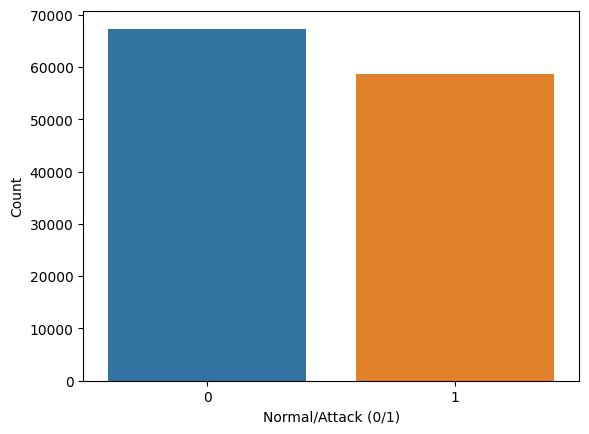

In [ ]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Normal/Attack (0/1)')
plt.ylabel('Count');

In [ ]:
le=LabelEncoder()
clm=['protocol_type', 'service', 'flag', 'attack']
for x in clm:
    df[x]=le.fit_transform(df[x])

In [ ]:
df = df.drop(['attack', 'level'], axis=1)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_flag
0,0,2,44,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,0
1,0,1,49,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,1
2,0,1,24,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,0
3,0,1,24,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0
4,0,1,49,1,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,1


####Split data set

In [ ]:
x_train = df.drop(['attack_flag'], axis=1)
y_train=df['attack_flag']

X_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train, test_size=0.20, random_state=42)

####Build and train model



In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Model Parameters
kernel_size = 9
pool_size = 2
lstm_units = 16
dropout_rate = 0.2

# Training Parameters
batch_size = 250
epochs = 10

# Model Building
model = Sequential()
model.add(Conv1D(32, kernel_size, padding="same", input_shape=(X_train.shape[1], 1), activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(units=lstm_units, dropout=dropout_rate))
model.add(Dense(units=1, activation='sigmoid'))

# Model Compilation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# Model Training
model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 41, 32)            320       
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 32)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3473 (13.57 KB)
Trainable params: 3473 (13.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
363/363 [==============================] - 15s 6ms/step - loss: 0.2694 - accu

788/788 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99     13386
      Attack       0.99      0.98      0.99     11809

    accuracy                           0.99     25195
   macro avg       0.99      0.99      0.99     25195
weighted avg       0.99      0.99      0.99     25195



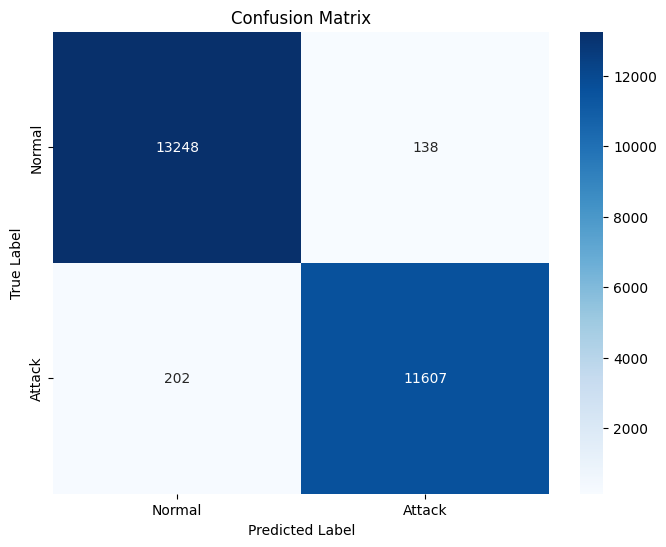

In [ ]:
def evaluate_model():
  X_test_processed = np.array(X_test)
  X_test_processed = np.reshape(X_test_processed, (X_test_processed.shape[0], X_test_processed.shape[1], 1))
  y_pred = model.predict(X_test_processed)
  # Convert probabilities to binary predictions
  y_pred_binary = (y_pred > 0.5).astype(int)

  # Now we calculate the confusion matrix
  cm = confusion_matrix(Y_test, y_pred_binary)

  # To get precision, recall, and F1-score, you can use sklearn's classification report
  from sklearn.metrics import classification_report
  print(classification_report(Y_test, y_pred_binary, target_names=['Normal', 'Attack']))
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()


evaluate_model()

# Test model

In [ ]:
def test_model(test_data):
  X_test_processed = np.array(test_data)
  X_test_processed = np.reshape(X_test_processed, (X_test_processed.shape[0], X_test_processed.shape[1], 1))
  y =  model.predict(X_test_processed)
  res = []
  for f in y:
      res.append(f[0])
  return res

# Testing bloom filter functions





In [ ]:
def test_learned_bloom_filter(bloom, test_data, tau, predictions):
    labels = test_data['attack_flag'].to_numpy()
    false_positives = 0
    false_negatives = 0
    query_times = []
    for i, (idx, row) in tqdm(enumerate(test_data.iterrows()), total=len(test_data)):
        x = pd.DataFrame([row.drop('attack_flag')])
        start_time = time.time()
        bloom_filter_contains_item = bloom.__contains__(x)
        query_time = time.time() - start_time
        query_times.append(query_time)
        if predictions[i] < tau and labels[i] == 1:
            false_negatives += 1

        if predictions[i] >= tau:
            if labels[i] == 0 and bloom_filter_contains_item:
                false_positives += 1

        if predictions[i] < tau:
            item_added = hash(tuple(x)) in added_to_bloom_filters
            if not bloom_filter_contains_item and item_added:
                false_negatives += 1


    # Calculate the false positive rate
    fpr = false_positives / len(test_data)
    fnr = false_negatives / len(test_data)
    # Calculate the average query time
    avg_query_time = sum(query_times) / len(query_times)

    return fpr, fnr, avg_query_time

In [ ]:
def test_post_learned_bloom_filter(bloom, test_data, tau, predictions):
    labels = test_data['attack_flag'].to_numpy()
    false_positives = 0
    false_negatives = 0
    query_times = []
    for i, (idx, row) in tqdm(enumerate(test_data.iterrows()), total=len(test_data)):
        x = pd.DataFrame([row.drop('attack_flag')])
        start_time = time.time()
        bloom_filter_contains_item = bloom.__contains__(x)
        query_time = time.time() - start_time
        query_times.append(query_time)
        item_added = hash(tuple(x)) in added_to_bloom_filters
        if bloom_filter_contains_item and predictions[i] < tau and labels[i] == 0:
            false_positives += 1

        if predictions[i] < tau and labels[i] == 1:
            false_negatives += 1

    # Calculate the false positive rate
    fpr = false_positives / len(test_data)
    fnr = false_negatives / len(test_data)
    # Calculate the average query time
    avg_query_time = sum(query_times) / len(query_times)

    return fpr, fnr, avg_query_time

In [ ]:
def test_normal_bloom_filter(bloom, test_data):
  false_positives = 0
  false_negatives = 0
  query_times = []
  labels = test_data['attack_flag'].to_numpy()
  for i, (idx, row) in tqdm(enumerate(test_data.iterrows()), total=len(test_data)):
        x = pd.DataFrame([row.drop('attack_flag')])
        start_time = time.time()
        bloom_filter_contains_item = bloom.__contains__(x)
        query_time = time.time() - start_time
        query_times.append(query_time)
        item_added = hash(tuple(x)) in added_to_bloom_filters
        if bloom_filter_contains_item and hash(tuple(x)) not in added_to_bloom_filters:
          false_positives += 1
        if not bloom_filter_contains_item and labels[i] == 1:
          false_negatives += 1
  # Calculate the false positive rate
  fpr = false_positives / len(test_data)
  fnr = false_negatives / len(test_data)
  # Calculate the average query time
  avg_query_time = sum(query_times) / len(query_times)
  return fpr, fnr, query_time

# Compare different learned bloom filter variances (Variant 1 & 2) vs normal bloom filter

In [ ]:
import time
from pympler import asizeof
from pybloom_live import BloomFilter

random.seed(1000)

tau = 0.9
attacks_to_add =  df[df['attack_flag'] == 1].sample(frac=0.5)

added_to_bloom_filters = set()
test_data = df.sample(frac=0.1)

normal_bloom = BloomFilter(capacity=len(attacks_to_add), error_rate=0.001)
learned_bloom = BloomFilter(capacity=len(attacks_to_add), error_rate=0.001)
post_learned_bloom = BloomFilter(capacity=len(attacks_to_add), error_rate=0.001)

for i, (idx, row) in tqdm(enumerate(attacks_to_add.iterrows()), total=len(attacks_to_add)):
  x = tuple(row.drop('attack_flag'))
  normal_bloom.add(x)
  learned_bloom.add(x)
  post_learned_bloom.add(x)
  added_to_bloom_filters.add(hash(tuple(row)))


  0%|          | 0/29315 [00:00<?, ?it/s]

In [ ]:
fpr_normal_bloom, fnr_normal_bloom, time_normal_bloom = test_normal_bloom_filter(normal_bloom, test_data)
predictions = test_model(test_data.drop(['attack_flag'], axis=1))
fpr_learned_bloom, fnr_learned_bloom, time_learned_bloom = test_learned_bloom_filter(learned_bloom, test_data, tau, predictions)
fpr_post_learned_bloom, fnr_post_learned_bloom, time_post_learned_bloom = test_post_learned_bloom_filter(post_learned_bloom, test_data, tau, predictions)

ml_model_size = asizeof.asizeof(model)
normal_bloom_size = asizeof.asizeof(normal_bloom)
learned_bloom_size = asizeof.asizeof(learned_bloom)
post_learned_bloom_size = asizeof.asizeof(post_learned_bloom)

  0%|          | 0/12597 [00:00<?, ?it/s]

394/394 [==============================] - 1s 2ms/step


  0%|          | 0/12597 [00:00<?, ?it/s]

  0%|          | 0/12597 [00:00<?, ?it/s]

In [ ]:
fp_df = pd.DataFrame({
    "FP Rate (Normal BF)": [fpr_normal_bloom],
    "FP Rate (ML + BF)": [fpr_learned_bloom],
    "FP Rate (BF + ML)": [fpr_post_learned_bloom],
}, index=[""])

fn_df = pd.DataFrame({
    "Missed Rate": [fnr_normal_bloom],
    "Missed Rate (ML + BF)": [fnr_learned_bloom],
    "Missed Rate (BF + ML)": [fnr_post_learned_bloom],
}, index=[""])

overall_metrics_df = pd.DataFrame({
    "Normal BF": [time_normal_bloom, normal_bloom_size / 1024],
    "ML + BF": [time_learned_bloom, (learned_bloom_size + ml_model_size) / 1024],
    "BF + ML": [time_post_learned_bloom, (post_learned_bloom_size + ml_model_size) / 1024],
}, index=["Average Query Time (seconds)", "Memory Footprint (kB)"])

print("Comparison of False Positive rates")
print(fp_df)


print("\nComparison of Missed Rates")
print(fn_df)

print("\nOverall Performance Metrics:")
print(overall_metrics_df)

Comparison of False Positive rates
  FP Rate (Normal BF)  FP Rate (ML + BF)  FP Rate (BF + ML)
             0.001667                0.0           0.001111

Comparison of Missed Rates
  Missed Rate  Missed Rate (ML + BF)  Missed Rate (BF + ML)
      0.46519               0.025323               0.025323

Overall Performance Metrics:
                              Normal BF      ML + BF      BF + ML
Average Query Time (seconds)   0.006902     0.006849     0.006948
Memory Footprint (kB)         52.445312  1311.500000  1311.500000


In [ ]:
error_rates = [0.0001*i for i in range(1, 6)]
fpr_normal_bloom_results = []
fpr_learned_bloom_results = []
fpr_post_learned_bloom_results = []

fnr_learned_bloom_results = []
fnr_post_learned_bloom_results = []

time_normal_bloom_results = []
time_learned_bloom_results = []
time_post_learned_bloom_results = []

memory_normal_bloom_results = []
memory_learned_bloom_results = []
memory_post_learned_bloom_results = []

for er in tqdm(range(len(error_rates))):

  normal_bloom = BloomFilter(capacity=1000000, error_rate=error_rates[er])
  learned_bloom = BloomFilter(capacity=1000000, error_rate=error_rates[er])
  post_learned_bloom = BloomFilter(capacity=1000000, error_rate=error_rates[er])

  for i, (idx, row) in tqdm(enumerate(attacks_to_add.iterrows()), total=len(attacks_to_add)):
    x = tuple(row.drop('attack_flag'))
    normal_bloom.add(x)
    learned_bloom.add(x)
    post_learned_bloom.add(x)
    added_to_bloom_filters.add(hash(tuple(row)))

  fpr_normal_bloom, fnr_normal_bloom, time_normal_bloom = test_normal_bloom_filter(normal_bloom, test_data)
  predictions = test_model(test_data.drop(['attack_flag'], axis=1))
  fpr_learned_bloom, fnr_learned_bloom, time_learned_bloom = test_learned_bloom_filter(learned_bloom, test_data, tau, predictions)
  fpr_post_learned_bloom, fnr_post_learned_bloom, time_post_learned_bloom = test_post_learned_bloom_filter(post_learned_bloom, test_data, tau, predictions)

  ml_model_size = asizeof.asizeof(model)
  normal_bloom_size = asizeof.asizeof(normal_bloom)
  learned_bloom_size = asizeof.asizeof(learned_bloom)
  post_learned_bloom_size = asizeof.asizeof(post_learned_bloom)

  memory_normal_bloom_results.append(normal_bloom_size / 1024)
  memory_learned_bloom_results.append((learned_bloom_size + ml_model_size) / 1024)
  memory_post_learned_bloom_results.append((post_learned_bloom_size + ml_model_size) / 1024)


  # Store results
  fpr_normal_bloom_results.append(fpr_normal_bloom)
  fpr_learned_bloom_results.append(fpr_learned_bloom)
  fpr_post_learned_bloom_results.append(fpr_post_learned_bloom)

  fnr_learned_bloom_results.append(fnr_learned_bloom)
  fnr_post_learned_bloom_results.append(fnr_post_learned_bloom)

  time_normal_bloom_results.append(time_normal_bloom)
  time_learned_bloom_results.append(time_learned_bloom)
  time_post_learned_bloom_results.append(time_post_learned_bloom)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/29315 [00:00<?, ?it/s]

  0%|          | 0/12597 [00:00<?, ?it/s]

394/394 [==============================] - 1s 2ms/step


  0%|          | 0/12597 [00:00<?, ?it/s]

  0%|          | 0/12597 [00:00<?, ?it/s]

  0%|          | 0/29315 [00:00<?, ?it/s]

  0%|          | 0/12597 [00:00<?, ?it/s]

394/394 [==============================] - 1s 2ms/step


  0%|          | 0/12597 [00:00<?, ?it/s]

  0%|          | 0/12597 [00:00<?, ?it/s]

  0%|          | 0/29315 [00:00<?, ?it/s]

  0%|          | 0/12597 [00:00<?, ?it/s]

394/394 [==============================] - 1s 2ms/step


  0%|          | 0/12597 [00:00<?, ?it/s]

  0%|          | 0/12597 [00:00<?, ?it/s]

  0%|          | 0/29315 [00:00<?, ?it/s]

  0%|          | 0/12597 [00:00<?, ?it/s]

394/394 [==============================] - 1s 2ms/step


  0%|          | 0/12597 [00:00<?, ?it/s]

  0%|          | 0/12597 [00:00<?, ?it/s]

  0%|          | 0/29315 [00:00<?, ?it/s]

  0%|          | 0/12597 [00:00<?, ?it/s]

394/394 [==============================] - 1s 2ms/step


  0%|          | 0/12597 [00:00<?, ?it/s]

  0%|          | 0/12597 [00:00<?, ?it/s]

# Plotting


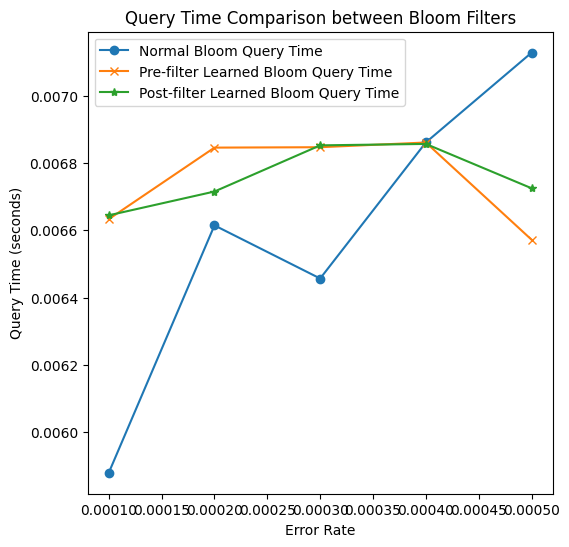

In [ ]:
import matplotlib.pyplot as plt

# Plotting the query times
plt.figure(figsize=(6, 6))
plt.plot(error_rates, time_normal_bloom_results, label='Normal Bloom Query Time', marker='o')
plt.plot(error_rates, time_learned_bloom_results, label='Pre-filter Learned Bloom Query Time', marker='x')
plt.plot(error_rates, time_post_learned_bloom_results, label='Post-filter Learned Bloom Query Time', marker='*')

plt.xlabel('Error Rate')
plt.ylabel('Query Time (seconds)')
plt.title('Query Time Comparison between Bloom Filters')
plt.legend()
plt.show()

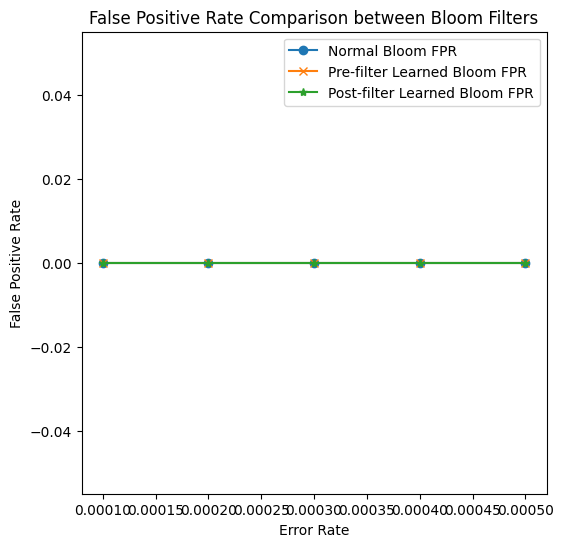

In [ ]:
# Plotting the false positive rates
plt.figure(figsize=(6, 6))
plt.plot(error_rates, fpr_normal_bloom_results, label='Normal Bloom FPR', marker='o')
plt.plot(error_rates, fpr_learned_bloom_results, label='Pre-filter Learned Bloom FPR', marker='x')
plt.plot(error_rates, fpr_post_learned_bloom_results, label='Post-filter Learned Bloom FPR', marker='*')

plt.xlabel('Error Rate')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate Comparison between Bloom Filters')
plt.legend()
plt.show()

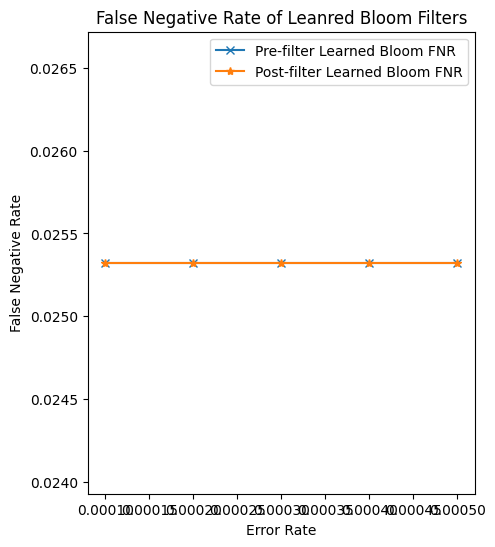

In [ ]:
# Plotting the false negative rates
plt.figure(figsize=(5, 6))
plt.plot(error_rates, fnr_learned_bloom_results, label='Pre-filter Learned Bloom FNR', marker='x')
plt.plot(error_rates, fnr_post_learned_bloom_results, label='Post-filter Learned Bloom FNR', marker='*')
plt.xlabel('Error Rate')
plt.ylabel('False Negative Rate')
plt.title('False Negative Rate of Leanred Bloom Filters')
plt.legend()
plt.show()

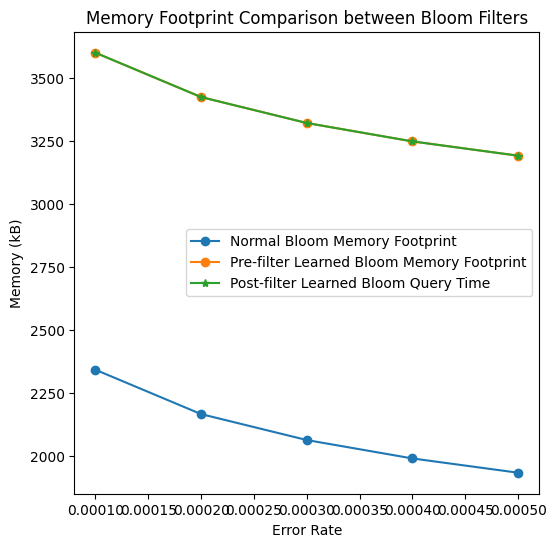

In [ ]:
# Plotting the memory footprint
plt.figure(figsize=(6, 6))
plt.plot(error_rates, memory_normal_bloom_results, label='Normal Bloom Memory Footprint', marker='o')
plt.plot(error_rates, memory_learned_bloom_results, label='Pre-filter Learned Bloom Memory Footprint', marker='o')
plt.plot(error_rates, memory_post_learned_bloom_results, label='Post-filter Learned Bloom Query Time', marker='*')

plt.xlabel('Error Rate')
plt.ylabel('Memory (kB)')
plt.title('Memory Footprint Comparison between Bloom Filters')
plt.legend()
plt.show()